# Fallback - Product Propensity Scoring
* StellarAlgo Data Science
* Ryan Kazmerik
* Oct 19, 2022

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pycaret.classification import *
from shared_utilities import helpers

In [28]:
CLUSTER = "prod-app"
DATABASE = "stlrcanucks"
LKUPCLIENTID = "7"
SCORING_YEAR = 2022

## Model Training

In [29]:
df = helpers.get_product_propensity_dataset(
    cluster=CLUSTER,
    database=DATABASE,
    lkupclientid=LKUPCLIENTID,
    scoring_year=SCORING_YEAR,
    type_flag=0
)

df.shape

Attempting to automatically open the SSO authorization page in your default browser.
If the browser does not open or you wish to use a different device to authorize this request, open the following URL:

https://device.sso.us-east-1.amazonaws.com/

Then enter the code:

NDCR-STSN
Successfully logged into Start URL: https://stellaralgo.awsapps.com/start#/
Authorized as AROASQ4JELIXYLYV6P4UV:rkazmerik@stellaralgo.com


(699157, 27)

In [30]:
# choose the features for the stellar base PP model
features = [
    "atp_last",
    "attendedpct_last",
    "attendedpct_prior",
    "attendance_current",
    "attended_last",
    "attended_prior",
    "clientcode",
    "dimcustomermasterid",
    "date_last_save",
    "date_last_send",
    "date_last_touch",
    "events_last",
    "events_prior",
    "distance",
    "events_current",
    "lkupclientid",
    "opens",
    "opens_prior",
    "product",
    "product_current",
    "product_last",
    "seasonyear",
    "sends",
    "sends_prior",
    "spend_current",
    "tenure",
    "volume_current"
]

# copy your main dataframe
df_dataset = df

# creating the training and evaluation dataframe
df_dataset = df_dataset[features]

# limiting classes to only product plans
product_plans = ["Full Season", "Half Season", "Quarter", "Mini Pack"]

df_dataset = df_dataset[df_dataset["product"].isin(product_plans)]

df_train = df_dataset.sample(frac=0.90, random_state=786)
df_eval = df_dataset.drop(df_train.index)

df_train.reset_index(drop=True, inplace=True)
df_eval.reset_index(drop=True, inplace=True)

# print out the number of records for training and eval
print('Data for Modeling: ' + str(df_train.shape))
print('Unseen Data For Predictions: ' + str(df_eval.shape), end="\n\n")

Data for Modeling: (14342, 27)
Unseen Data For Predictions: (1594, 27)



In [31]:
setup(
    data= df_train, 
    target="product", 
    train_size = 0.90,
    data_split_shuffle=True,
    ignore_features=[
        "attended_last",
        "attendedpct_last",
        "clientcode",
        "date_last_save",
        "date_last_send",
        "date_last_touch",
        "dimcustomermasterid",
        "distance",
        "events_current",
        "lkupclientid",
        "opens",
        "opens_prior",
        "product_current",
        "product_last",
        "seasonyear",
        "sends",
        "sends_prior",
        #"spend_current",
        "volume_current"
    ],
    silent=True,
    verbose=False,
    categorical_features=[
        #"product_current",
        #"product_last",
    ],
    numeric_features=[
        "atp_last",
        #"attendance_current",
        "attended_last",
        "attended_prior",
        "events_last",
        "events_prior",
        #"spend_current",
        "tenure"
    ]
);

In [32]:
model_matrix = compare_models(
    fold=10,
    include=["rf"]
)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.8653,0.9470,0.6727,0.8609,0.8625,0.7412,0.7416,0.9740


In [33]:
best_model = create_model(model_matrix);
final_model = finalize_model(best_model);

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8606,0.9527,0.6702,0.8581,0.8591,0.7348,0.7350
1,0.8668,0.9485,0.6756,0.8645,0.8652,0.7473,0.7475
2,0.8652,0.9505,0.6831,0.8598,0.8619,0.7401,0.7405
3,0.8668,0.9436,0.6581,0.8606,0.8626,0.7419,0.7427
4,0.8668,0.9489,0.6678,0.8638,0.8650,0.7433,0.7437
5,0.8714,0.9418,0.6610,0.8638,0.8662,0.7505,0.7512
6,0.8652,0.9449,0.6852,0.8609,0.8622,0.7411,0.7415
7,0.8605,0.9448,0.6723,0.8561,0.8579,0.7306,0.7310
8,0.8698,0.9517,0.6712,0.8650,0.8665,0.7502,0.7505


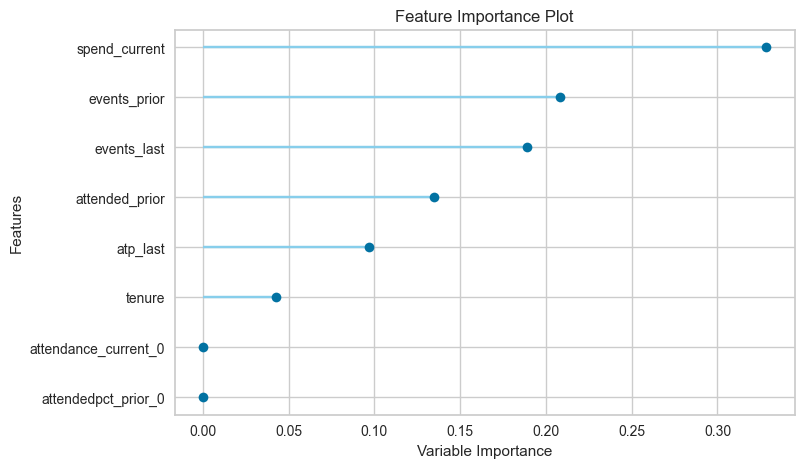

In [34]:
plot_model(final_model, plot='feature')

## Model Inference

### Let's load in our inference data and get retention scores using the model:

In [35]:
df_inference = helpers.get_product_propensity_dataset(
    cluster=CLUSTER,
    database=DATABASE,
    lkupclientid=LKUPCLIENTID,
    scoring_year=SCORING_YEAR,
    type_flag=1
)

# remove the target column from the inference df
df_inference = df_inference.drop(columns=["product"], axis=1)

df_inference.shape

Authorized as AROASQ4JELIXYLYV6P4UV:rkazmerik@stellaralgo.com


(387707, 26)

In [36]:
df_scores = predict_model(final_model, data=df_inference)

## Upsell Leads

In [37]:
df_upsell = df_scores[df_scores["product_current"].isin(product_plans)]

df_upsell_aggs = df_upsell.groupby(["Label","product_current"]).agg({
    "Label": "count",
})
df_upsell_aggs.columns = ["count"]

df_upsell_aggs

count
Label       product_current       
Full Season Full Season        251
            Half Season         53
            Mini Pack            6
            Quarter             15
Half Season Full Season         10
            Half Season        138
            Mini Pack            3
            Quarter             11
Mini Pack   Full Season          3
            Mini Pack            8
            Quarter              1
Quarter     Full Season         18
            Half Season         70
            Mini Pack           25
            Quarter            560

## Individual + None Leads

In [38]:
df_other = df_scores[df_scores["product_current"].isin(["Individual", "None"])]

### Let's examine the top 20 Full Season leads in this grouping:

In [39]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

df_other[df_other["Label"]=="Full Season"].sort_values(by="Score", ascending=False).head(20)

,lkupclientid,clientcode,dimcustomermasterid,seasonyear,distance,tenure,events_prior,attended_prior,attendedpct_prior,events_last,attended_last,attendedpct_last,atp_last,product_last,product_current,spend_current,volume_current,attendance_current,events_current,sends,sends_prior,opens,opens_prior,date_last_send,date_last_touch,date_last_save,Label,Score
45110,7,CANUCKS,28879,2022,5.04,7,200,135,0.67500000000000000,37,24,0.64864864864864864,45.05,Full Season,None,5036.70,108,0E-17,35,30.0,12.0,42.0,21.0,2022-10-13,None,2022-10-19,Full Season,1.00
59436,7,CANUCKS,81301,2022,23.84,1,36,28,0.77777777777777777,0,0,0E-17,0.00,None,None,15885.96,224,0.77777777777777777,36,31.0,17.0,142.0,93.0,2022-10-13,None,2022-10-19,Full Season,1.00
198014,7,CANUCKS,475845,2022,6.96,7,180,134,0.74444444444444444,37,35,0.94594594594594594,42.57,None,None,3455.40,78,0.14285714285714285,35,33.0,20.0,48.0,48.0,2022-10-13,None,2022-10-18,Full Season,1.00
21629,7,CANUCKS,45564,2022,6.52,6,196,152,0.77551020408163265,38,34,0.89473684210526315,70.65,None,None,4882.40,72,0E-17,36,26.0,12.0,6.0,4.0,2022-10-13,None,2022-10-14,Full Season,1.00
39130,7,CANUCKS,37900,2022,1.83,7,90,89,0.98888888888888888,0,0,0E-17,0.00,None,None,0.00,0,0E-17,0,NaN,NaN,NaN,NaN,None,None,2022-10-13,Full Season,0.99
252761,7,CANUCKS,650881,2022,270.77,6,207,143,0.69082125603864734,38,2,0.05263157894736842,55.41,Full Season,None,7954.40,144,0.27777777777777777,36,30.0,13.0,20.0,17.0,2022-10-13,None,2022-10-19,Full Season,0.99
171375,7,CANUCKS,504372,2022,11.49,7,90,90,1.00000000000000000,0,0,0E-17,-0.00,None,None,0.00,0,0E-17,0,0.0,1.0,0.0,0.0,2022-04-29,None,2022-10-13,Full Season,0.99
175116,7,CANUCKS,404658,2022,3689.61,7,90,89,0.98888888888888888,0,0,0E-17,0.00,None,None,0.00,0,0E-17,0,NaN,NaN,NaN,NaN,None,None,2022-10-13,Full Season,0.99
235909,7,CANUCKS,670861,2022,84.72,7,163,127,0.77914110429447852,38,38,1.00000000000000000,56.07,None,None,3977.20,72,0.05555555555555555,36,44.0,23.0,94.0,53.0,2022-10-14,None,2022-10-14,Full Season,0.99
161684,7,CANUCKS,395980,2022,3697.87,7,90,89,0.98888888888888888,0,0,0E-17,0.00,None,None,0.00,0,0E-17,0,NaN,NaN,NaN,NaN,None,None,2022-10-13,Full Season,0.99
